In [1]:
import matplotlib
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ray
import json
import os
import mlflow

In [2]:
import os
import gym
import ray
import tqdm
import json
import pickle
import argparse
from os import path
from dynaconf import Dynaconf
from ray.rllib.algorithms.dqn import DQN
import replay_buffer
from replay_buffer.ber import BlockReplayBuffer
from ray.rllib.utils.replay_buffers import ReplayBuffer
from ray.rllib.env.wrappers.atari_wrappers import wrap_deepmind
from ray.tune.logger import UnifiedLogger
from utils import convert_np_arrays, check_path

/home/seventheli/conda/envs/hpc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
mlflow.set_tracking_uri("http://10.56.238.20:9999")
client = mlflow.MlflowClient()

In [9]:
# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Create a color palette
palette = sns.color_palette("colorblind", 4)

# Create a dictionary that maps each unique value to a color
palette_dict = dict(zip([1, 8, 16, 32], palette))

In [10]:
experiments = { "BeamRider": {}, "Qbert": {}, "SpaceInvaders": {}, "Breakout": {}}
configs = { "BeamRider": {}, "Qbert": {}, "SpaceInvaders": {}, "Breakout": {}}

In [11]:
client = mlflow.client.MlflowClient()

In [12]:
mapper = {"Qbert": "Q*bert", "BeamRider": "BeamRider", "SpaceInvaders": "SpaceInvaders", "Breakout": "Breakout"}

In [13]:
for each in experiments.keys():
    path = os.path.join("/home/seventheli/backup/Local/Loggings", each)
    experiment_mlflow = mlflow.get_experiment_by_name(mapper[each])
    mlflow.set_experiment(mapper.get(each))
    for experiment in os.listdir(path):
        location = os.path.join(path, experiment)
        if len(os.listdir(location)) <= 100:
            continue
        else:
            mlflow_run = client.search_runs(experiment_ids=experiment_mlflow.experiment_id, 
                   filter_string='attributes.run_name="%s"' % experiment)
            if len(mlflow_run) != 0:
                run_info = mlflow_run[0]
                bz = 1
                if run_info.data.params.get("sub_buffer_size", None) is not None:
                    bz = int(run_info.data.params.get("sub_buffer_size"))
                buffer = run_info.data.params["type"]
                experiments[each][experiment] = []
                for file in os.listdir(location):
                    try:
                        with open(os.path.join(location, file), "r") as f:
                            experiments[each][experiment].append(json.load(f))
                    except:
                        print(file)
                configs[each][experiment] = {"BZ": bz, "Type": buffer}
            else:
                checkpoints = os.path.join("/home/seventheli/backup/Local/Checkpoints", each)
                checkpoints = os.path.join(checkpoints, experiment)
                experiments[each][experiment] = []
                for file in os.listdir(location):
                    try:
                        with open(os.path.join(location, file), "r") as f:
                            experiments[each][experiment].append(json.load(f))
                    except:
                        print(file)
                if os.path.exists(checkpoints):
                    with open(os.path.join(checkpoints, experiment +"_config.pyl"), "rb") as f:
                        _config = pickle.load(f)
                        configs[each][experiment] = {"BZ": _config["replay_buffer_config"].get("sub_buffer_size", 1),
                                                     "Type": _config["replay_buffer_config"]["type"].__name__}

In [14]:
experiments["SpaceInvaders"].keys()

dict_keys(['DQN_BER_SpaceInvadersNoFrameskip_20230717', 'DQN_ER_SpaceInvadersNoFrameskip_20230706', 'DQN_BER_SpaceInvadersNoFrameskip_20230727', 'APEX_DDQN_SpaceInvadersNoFrameskip_DPER_20230713', 'DDQN_PER_SpaceInvadersNoFrameskip_20230720', 'DQN_ER_SpaceInvadersNoFrameskip_20230730', 'DDQN_PBER_SpaceInvadersNoFrameskip_20230716', 'DQN_ER_SpaceInvadersNoFrameskip_20230727', 'DDQN_PBER_SpaceInvadersNoFrameskip_20230721', 'DDQN_PBER_SpaceInvadersNoFrameskip_20230720', 'DDQN_PBER_SpaceInvadersNoFrameskip_20230706', 'DDQN_PER_SpaceInvadersNoFrameskip_20230721', 'DDQN_PBER_SpaceInvadersNoFrameskip_20230714', 'APEX_DDQN_SpaceInvadersNoFrameskip_DPBER_20230713', 'DQN_BER_SpaceInvadersNoFrameskip_20230706', 'DDQN_PER_SpaceInvadersNoFrameskip_20230706'])

In [15]:
configs["SpaceInvaders"].keys()

dict_keys(['DQN_BER_SpaceInvadersNoFrameskip_20230727', 'APEX_DDQN_SpaceInvadersNoFrameskip_DPER_20230713', 'DQN_ER_SpaceInvadersNoFrameskip_20230730', 'DDQN_PBER_SpaceInvadersNoFrameskip_20230721', 'DDQN_PER_SpaceInvadersNoFrameskip_20230721'])

In [16]:
selected = {
    "Qbert": [],
    "Breakout": [],
    "SpaceInvaders": [],
    "BeamRider": [] 
}
for games in configs.keys():
    for experiment in configs[games]:
        _config = configs[games][experiment]
        if _config["Type"] in ["BlockReplayBuffer", "ReplayBuffer" ] and experiment[0:3] == "DQN":
            selected[games].append([experiment, _config["BZ"]])

In [17]:
experiments[each].keys()

dict_keys(['DDQN_PER_BreakoutNoFrameskip_20230726', 'DQN_ER_BreakoutNoFrameskip_20230705', 'DDQN_PBER_BreakoutNoFrameskip_20230726', 'DQN_BER_BreakoutNoFrameskip_20230719', 'DQN_ER_BreakoutNoFrameskip_20230721', 'DDQN_PER_BreakoutNoFrameskip_20230712', 'DQN_BER_BreakoutNoFrameskip_20230721', 'DQN_BER_BreakoutNoFrameskip_20230705', 'DDQN_PBER_BreakoutNoFrameskip_20230712', 'DDQN_PBER_BreakoutNoFrameskip_20230731'])

In [18]:
sampler = {}
tags = ["episode_reward_max", "episode_reward_min", "episode_reward_mean", "episodes_this_iter"]

for each in selected.keys():
    _experiments = []
    for select in selected[each]:
        steps = []
        for info in experiments[each][select[0]]:
            _info = {
                **{i : info["sampler_results"][i] for i in tags},
                **info["counters"],
                **info["timers"],
                **{
                    "episodes_total" : info["episodes_total"],
                    "training_iteration" : info["training_iteration"],
                    "time_this_iter_s" : info["time_this_iter_s"],
                    "time_total_s" : info["time_total_s"]
                }
            }
            steps.append(_info)
        steps = pd.DataFrame(steps).sort_values("time_total_s")
        steps["size"] = select[1]
        steps["exp"] = select[0]
        _experiments.append(steps)
    sampler[each] = pd.concat(_experiments)

In [23]:
from matplotlib.ticker import FuncFormatter

def x_formatter(x, pos):
    return '{:.2f}e7'.format(x/1e7)
experiment = list(sampler.keys())[2]
data = sampler[experiment]
data[["exp", "size"]].value_counts()

exp                                        size
DQN_ER_SpaceInvadersNoFrameskip_20230730   1       1482
DQN_BER_SpaceInvadersNoFrameskip_20230727  8       1447
Name: count, dtype: int64

In [24]:
[i[0] for i in data[["exp", "size"]].value_counts().index.to_list()]

['DQN_ER_SpaceInvadersNoFrameskip_20230730',
 'DQN_BER_SpaceInvadersNoFrameskip_20230727']

<Axes: xlabel='time(h)', ylabel='episode reward(mean)'>

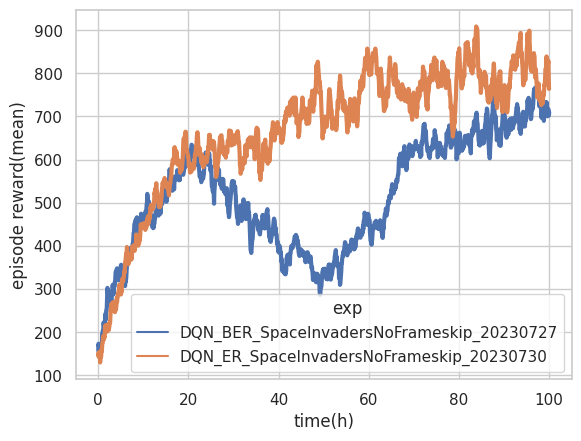

In [25]:

_data = data.copy()[["training_iteration", "num_env_steps_sampled", "time_total_s",
                     "episode_reward_max", "episode_reward_min", "episode_reward_mean", 
                     "size", "exp"]]
_data.columns = ["training iteration", "sampled frame", "time(s)",
                 "episode reward(max)", "episode reward(min)", "episode reward(mean)",
                 "size", "exp"]
_data["sampled frame"] = _data["sampled frame"] * 4
_data["time(h)"] = _data["time(s)"] / 3600
sns.lineplot(x="time(h)", y="episode reward(mean)", hue="exp", data=_data, linewidth=3)

<Axes: xlabel='trained frame', ylabel='episode reward(mean)'>

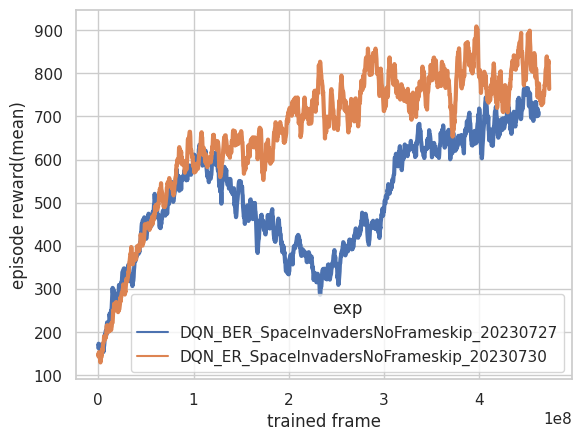

In [26]:
_data = data.copy()[["training_iteration", "num_env_steps_trained", "time_total_s",
                     "episode_reward_max", "episode_reward_min", "episode_reward_mean", 
                     "size", "exp"]]
_data.columns = ["training iteration", "trained frame", "time(s)",
                 "episode reward(max)", "episode reward(min)", "episode reward(mean)",
                 "size", "exp"]
_data["trained frame"] = _data["trained frame"] * 4
_data["time(h)"] = _data["time(s)"] / 3600
sns.lineplot(x="trained frame", y="episode reward(mean)", hue="exp", data=_data, linewidth=3)